# Практика.

ПОСТАНОВКА ЗАДАЧИ

К вам попали результаты A/A/B-тестирования от одного известного маркетплейса. 

sample_a, sample_c — АА-группы, sample_b — отдельная группа. 

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_sample_a = pd.read_csv("sample_a.csv")
df_sample_b = pd.read_csv("sample_b.csv")
df_sample_c = pd.read_csv("sample_c.csv")
df_item_prices = pd.read_csv("item_prices.csv")

In [4]:
df_item_prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [5]:
df_sample_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [6]:
df_sample_b.head()

,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1


In [7]:
df_sample_c.head()

,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2


- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

In [8]:
# удалим дубликаты
df_item_prices = df_item_prices.drop_duplicates(subset='item_id')

In [9]:
df_sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


In [10]:
df_sample_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


In [11]:
df_sample_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


In [12]:
df_a = pd.merge(df_sample_a, df_item_prices, how='left', on='item_id')
df_b = pd.merge(df_sample_b, df_item_prices, how='left', on='item_id')
df_c = pd.merge(df_sample_c, df_item_prices, how='left', on='item_id')

In [13]:
print(df_a.shape[0] == df_sample_a.shape[0],
      df_b.shape[0] == df_sample_b.shape[0],
      df_c.shape[0] == df_sample_c.shape[0])

True True True


При слиянии мы не получили лишней информации в датасетах.

In [77]:
df_a

,user_id,item_id,action_id,item_price
0,84636,360,1,1896
1,21217,9635,1,1699
2,13445,8590,1,846
3,38450,5585,1,1556
4,14160,2383,0,1956
...,...,...,...,...
1188907,22999,2401,1,1670
1188908,23700,4654,0,1080
1188909,18842,3707,1,656
1188910,32732,9198,1,1307


In [78]:
def df_group(dfr):
    df_count = dfr.groupby(['user_id', 'action_id']).agg('count').drop(columns=['item_id']).reset_index()
    df_sum = dfr.groupby(['user_id', 'action_id']).agg('sum').drop(columns=['item_id']).reset_index()
    df = pd.merge(df_count, df_sum, on=['user_id', 'action_id'])
    return df

In [92]:
# метрики
# ctr - отношение кликов к просмотрам товаров
# purchase rate - отношение покупок к просмотрам товаров
# gmv - оборот, сумма произведений количества покупок на стоимость покупки,
#      где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя)
# action_id - 0 — клик, 1 — просмотр и 2 — покупка

# ctr
def ctr(dframe, frame_id):
    a = dframe[(dframe['action_id'] == 0) & (dframe['user_id'] == frame_id)]['item_price_x']
    b = dframe[(dframe['action_id'] == 1) & (dframe['user_id'] == frame_id)]['item_price_x']
    return float(a)/float(b)

# purchase_rate
def purchase_rate(dframe, frame_id):
    a = dframe[(dframe['action_id'] == 2) & (dframe['user_id'] == frame_id)]['item_price_x']
    b = dframe[(dframe['action_id'] == 1) & (dframe['user_id'] == frame_id)]['item_price_x']
    return float(a)/float(b)

# gmv
def gvm(dframe, frame_id):
    a = dframe[(dframe['action_id'] == 2) & (dframe['user_id'] == frame_id)]['item_price_y']
    return float(a)


In [93]:
def frame_formation(df):
    dframe = df_group(df).copy()
    df_temp = dframe.copy()
    df_temp = df_temp.drop(columns=['action_id', 'item_price_x', 'item_price_y']).drop_duplicates()
    #'ctr', 'purchase_rate', 'gmv'
    df_temp['ctr'] = df_temp['user_id'].apply(lambda d: ctr(dframe, d))
    df_temp['purchase_rate'] = df_temp['user_id'].apply(lambda d: purchase_rate(dframe, d))
    df_temp['gvm'] = df_temp['user_id'].apply(lambda d: gvm(dframe, d))

    return df_temp

In [94]:
# sample_a, sample_c — АА-группы, sample_b — отдельная группа
# sample_a
frame_a = frame_formation(df_a).copy()
frame_a

,user_id,ctr,purchase_rate,gvm
0,241,0.187435,0.049215,47535.0
3,253,0.201047,0.038743,38676.0
6,362,0.186387,0.052356,58777.0
9,378,0.204188,0.053403,58152.0
12,475,0.206283,0.052356,48755.0
...,...,...,...,...
2973,99401,0.217801,0.040838,37264.0
2976,99543,0.186387,0.045026,49071.0
2979,99555,0.205236,0.063874,62560.0
2982,99868,0.214660,0.049215,46243.0


In [95]:
# sample_b
frame_b = frame_formation(df_b).copy()
frame_b

,user_id,ctr,purchase_rate,gvm
0,100038,0.174869,0.104712,103885.0
3,100099,0.168586,0.124607,127765.0
6,100164,0.146597,0.102618,99289.0
9,100321,0.188482,0.100524,101600.0
12,100397,0.160209,0.084817,89647.0
...,...,...,...,...
2973,199692,0.158115,0.098429,104024.0
2976,199772,0.149738,0.099476,99353.0
2979,199784,0.154974,0.096335,99715.0
2982,199868,0.166492,0.107853,109572.0


In [96]:
# sample_c
frame_c = frame_formation(df_c).copy()
frame_c


,user_id,ctr,purchase_rate,gvm
0,200225,0.205236,0.051309,49422.0
3,200278,0.212565,0.060733,55723.0
6,200282,0.218848,0.073298,82213.0
9,200325,0.193717,0.046073,47793.0
12,200441,0.211740,0.051363,51515.0
...,...,...,...,...
2967,299616,0.218848,0.056545,55344.0
2970,299648,0.214660,0.054450,52205.0
2973,299650,0.198953,0.056545,57714.0
2976,299672,0.209424,0.052356,58186.0


In [106]:
from scipy.stats import shapiro

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A44B862A30>,
      dtype=object)

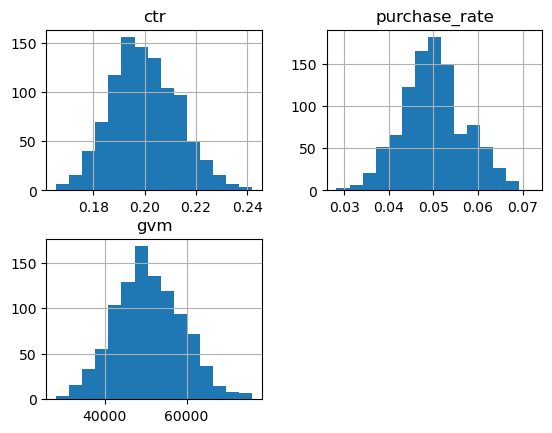

In [103]:
frame_a.drop(columns='user_id').hist(bins=15)

In [107]:
shapiro(frame_a.drop(columns='user_id'))

ShapiroResult(statistic=0.6621644496917725, pvalue=0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A44B902AF0>,
      dtype=object)

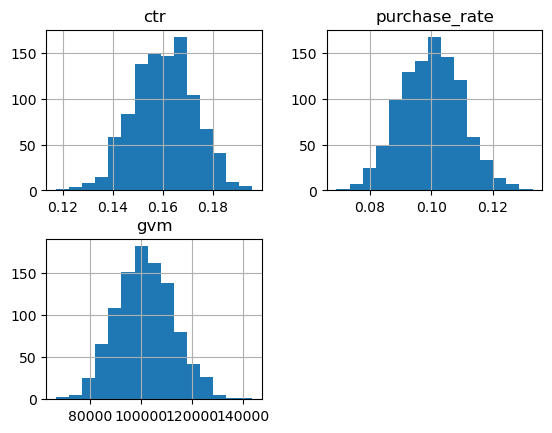

In [104]:
frame_b.drop(columns='user_id').hist(bins=15)

In [108]:
shapiro(frame_b.drop(columns='user_id'))

ShapiroResult(statistic=0.6456704139709473, pvalue=0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A44BCE8D60>,
      dtype=object)

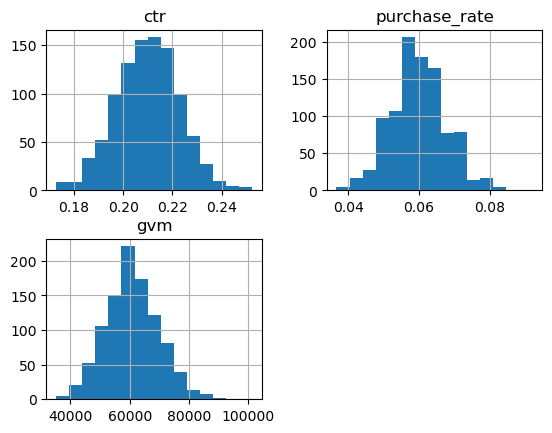

In [105]:
frame_c.drop(columns='user_id').hist(bins=15)

In [175]:
shapiro(frame_c.drop(columns='user_id'))

ShapiroResult(statistic=0.658390998840332, pvalue=0.0)

Во всех трех датасетах данные распределены нормально.

In [97]:
shapiro(frame_a.drop(columns='user_id'))


ShapiroResult(statistic=0.6621644496917725, pvalue=0.0)

In [178]:
from statsmodels.stats.weightstats import ztest

In [179]:
statistic, p_value = ztest(frame_a['ctr'], frame_c['ctr'])
print('ctr:', float(p_value))

statistic, p_value = ztest(frame_a['purchase_rate'], frame_c['purchase_rate'])
print('purchase_rate', float(p_value))

statistic, p_value = ztest(frame_a['gvm'], frame_c['gvm'])
print('gvm', float(p_value))

ctr: 3.905151645295016e-68
purchase_rate 1.3184284660385294e-197
gvm 7.723147571325108e-153


In [180]:
statistic, p_value = ztest(frame_a['ctr'], frame_b['ctr'])
print('ctr:', float(p_value))

statistic, p_value = ztest(frame_a['purchase_rate'], frame_b['purchase_rate'])
print('purchase_rate', float(p_value))

statistic, p_value = ztest(frame_a['gvm'], frame_b['gvm'])
print('gvm', float(p_value))

ctr: 0.0
purchase_rate 0.0
gvm 0.0


 Исходя из представленных данных, алгоритм B улучшает работу маркетплейса.